READING THE DATASET

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the uploaded dataset
df = pd.read_csv("heart_disease_uci.csv")

# Display the first few rows to understand the structure

print("Dimensions:", df.shape)
# Shows count of missing values per column
print("Missing values:\n",df.isnull().sum())


Dimensions: (920, 16)
Missing values:
 id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


In [14]:
# Identify columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Handle missing values
# Fill numerical columns with median
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Fill categorical columns with mode
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])


HEATMAP FORMATION 

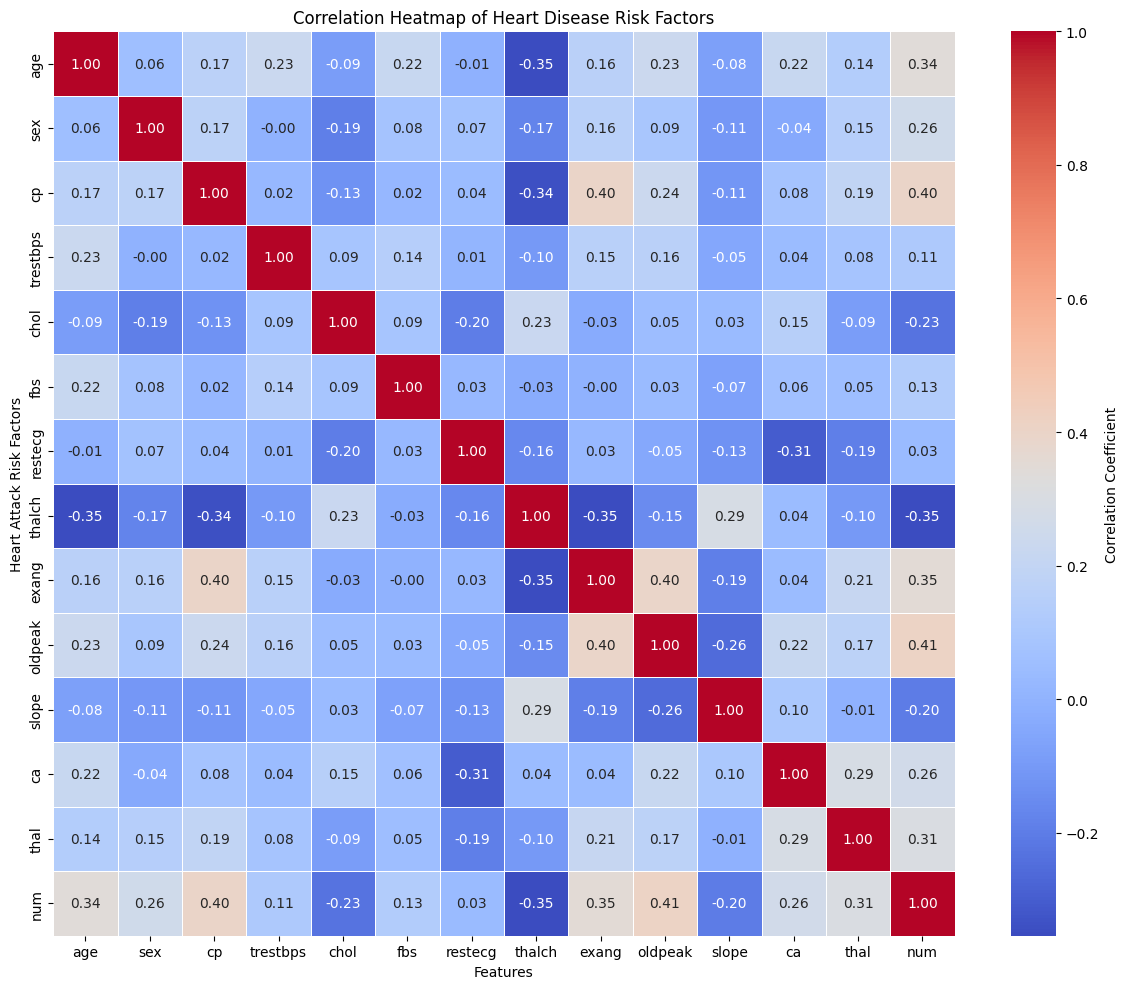

In [21]:
import seaborn as sns 

df_clean = df.copy()
# Fill boolean columns with default False (0)
df_clean['fbs'] = df_clean['fbs'].fillna(False).astype(int)
df_clean['exang'] = df_clean['exang'].fillna(False).astype(int)

# Step 2: Label encode categorical columns for correlation
df_clean[categorical_cols] = df_clean[categorical_cols].astype('category').apply(lambda x: x.cat.codes)

# Step 3: Drop non-informative columns
df_clean = df_clean.drop(columns=['id', 'dataset'], errors='ignore')  # errors='ignore' ensures safe dropping

# Step 4: Compute correlation matrix
corr_matrix = df_clean.corr()

# Step 5: Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}  # add legend title
)

plt.title('Correlation Heatmap of Heart Disease Risk Factors')
plt.xlabel("Features")
plt.ylabel("Heart Attack Risk Factors")
plt.tight_layout()
plt.show()

## CALCULATING Wi's - RISK FACTOR ANALYSIS 

In [16]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Encode categorical/binary features
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['fbs'] = df['fbs'].map({True: 1, False: 0})
df['exang'] = df['exang'].map({True: 1, False: 0})

cp_mapping = {'typical angina': 1, 'atypical angina': 2, 'non-anginal': 3, 'asymptomatic': 4}
thal_mapping = {'normal': 1, 'fixed defect': 2, 'reversable defect': 3}
df['cp'] = df['cp'].map(cp_mapping)
df['thal'] = df['thal'].map(thal_mapping)

# Drop unnecessary columns
df.drop(columns=['id', 'dataset'], inplace=True)

# Select high-correlation features
selected_features = ['ca', 'oldpeak', 'exang', 'age', 'cp', 'thalch', 'sex', 'thal']
X = df[selected_features]
y = (df['num'] > 0).astype(int)  # Binary target: heart disease (1) or not (0)

# Scale only numerical features to range [1, 5]
numerical_cols = ['ca', 'oldpeak', 'age', 'thalch']
scaler = MinMaxScaler(feature_range=(1, 5))
X_scaled_numerical = pd.DataFrame(scaler.fit_transform(X[numerical_cols]), columns=numerical_cols)

# Combine scaled numerical with unscaled categorical/binary columns
non_scaled_cols = [col for col in selected_features if col not in numerical_cols]
X_final = pd.concat([X[non_scaled_cols].reset_index(drop=True), X_scaled_numerical], axis=1)

# Train logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_final, y)

# Extract intercept and weights
intercept = model.intercept_[0]
weights_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Weight (Wi)': model.coef_[0]
})

In [17]:
results = []

for i in range(len(X_final)):
    xi = X_final.iloc[i]
    z_i = intercept + np.dot(weights_df['Weight (Wi)'].values, xi.values)
    rf_i = 1 / (1 + np.exp(-z_i))

    # Risk Level Mapping
    if 0 < rf_i < 0.2:
        risk_level = 1
    elif 0.2 <= rf_i < 0.4:
        risk_level = 2
    elif 0.4 <= rf_i < 0.6:
        risk_level = 3
    elif 0.6 <= rf_i < 0.8:
        risk_level = 4
    else:
        risk_level = 5

    results.append({
        'Patient_ID': i + 1,
        'Risk_Factor': round(rf_i, 4),
        'Risk_Level': risk_level
    })

# Convert results to DataFrame
risk_df = pd.DataFrame(results)
display(risk_df)

,Patient_ID,Risk_Factor,Risk_Level
0,1,0.3910,2
1,2,0.9851,5
2,3,0.9913,5
3,4,0.4665,3
4,5,0.0466,1
...,...,...,...
915,916,0.1768,1
916,917,0.1607,1
917,918,0.7877,4
918,919,0.6241,4


In [18]:
risk_df.to_csv("heart_attack_risk_scores1.csv", index=False)

In [19]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load your final output dataset
df_output = pd.read_excel("output_2.xlsx")  # Update the path if needed

# Step 1: Convert Risk_Level to binary
# Risk Levels 1 and 2 → 0 (Low Risk), 3 to 5 → 1 (High Risk)
df_output['Predicted_Binary'] = df_output['Risk_Level'].apply(lambda x: 0 if x <= 2 else 1)

# Step 2: Convert num to binary
# num = 0 → 0 (No Heart Disease), num = 1,2,3,4 → 1 (Heart Disease)
df_output['Actual_Binary'] = df_output['num'].apply(lambda x: 0 if x == 0 else 1)

# Step 3: Evaluate accuracy
accuracy = accuracy_score(df_output['Actual_Binary'], df_output['Predicted_Binary'])
conf_matrix = confusion_matrix(df_output['Actual_Binary'], df_output['Predicted_Binary'])
class_report = classification_report(df_output['Actual_Binary'], df_output['Predicted_Binary'])

# Step 4: Print results
print("Accuracy:", round(accuracy * 100, 2), "%")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 80.11 %

Confusion Matrix:
 [[286 125]
 [ 58 451]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76       411
           1       0.78      0.89      0.83       509

    accuracy                           0.80       920
   macro avg       0.81      0.79      0.79       920
weighted avg       0.80      0.80      0.80       920



Accuracy:  0.8011
Precision: 0.7830
Recall:    0.8861
F1 Score:  0.8313
AUC:       0.7910

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.70      0.76       411
           1       0.78      0.89      0.83       509

    accuracy                           0.80       920
   macro avg       0.81      0.79      0.79       920
weighted avg       0.80      0.80      0.80       920



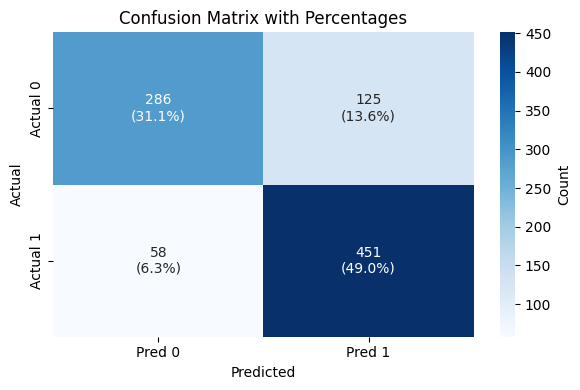

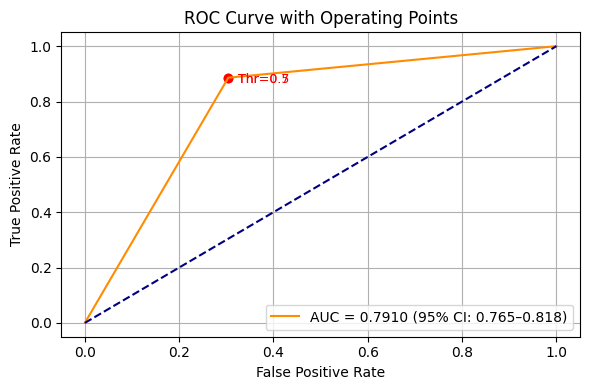

In [24]:
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns


# Evaluation Metrics
accuracy = accuracy_score(df_output['Actual_Binary'], df_output['Predicted_Binary'])
precision = precision_score(df_output['Actual_Binary'], df_output['Predicted_Binary'])
recall = recall_score(df_output['Actual_Binary'], df_output['Predicted_Binary'])
f1 = f1_score(df_output['Actual_Binary'], df_output['Predicted_Binary'])
auc_value = roc_auc_score(df_output['Actual_Binary'], df_output['Predicted_Binary'])
class_report = classification_report(df_output['Actual_Binary'], df_output['Predicted_Binary'])

# Print evaluation metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc_value:.4f}")
print("\nClassification Report:\n", class_report)

# Confusion matrix
conf_matrix = confusion_matrix(df_output['Actual_Binary'], df_output['Predicted_Binary'])

# Compute percentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum() * 100

# Combine counts and percentages for annotation
annot = np.empty_like(conf_matrix).astype(str)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        annot[i, j] = f"{conf_matrix[i, j]}\n({conf_matrix_percent[i, j]:.1f}%)"

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=annot, fmt='', cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Actual 0", "Actual 1"],
            cbar_kws={'label': 'Count'})

plt.title("Confusion Matrix with Percentages")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Get ROC curve values
fpr, tpr, thresholds = roc_curve(df_output['Actual_Binary'], df_output['Predicted_Binary'])
auc_value = roc_auc_score(df_output['Actual_Binary'], df_output['Predicted_Binary'])

# --- (1) Bootstrap AUC for 95% CI ---
n_bootstraps = 1000
rng = np.random.RandomState(42)
bootstrapped_scores = []

y_true = df_output['Actual_Binary'].values
y_pred = df_output['Predicted_Binary'].values

for i in range(n_bootstraps):
    indices = rng.randint(0, len(y_true), len(y_true))
    if len(np.unique(y_true[indices])) < 2:
        continue
    score = roc_auc_score(y_true[indices], y_pred[indices])
    bootstrapped_scores.append(score)

# Compute 95% CI
auc_lower = np.percentile(bootstrapped_scores, 2.5)
auc_upper = np.percentile(bootstrapped_scores, 97.5)

# --- (2) Plot ROC curve ---
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_value:.4f} (95% CI: {auc_lower:.3f}–{auc_upper:.3f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy')

# --- (3) Add chosen threshold operating points ---
chosen_thresholds = [0.5, 0.7]  # change as needed
for thr in chosen_thresholds:
    # Find the closest threshold index
    idx = np.argmin(np.abs(thresholds - thr))
    plt.scatter(fpr[idx], tpr[idx], marker='o', color='red')
    plt.text(fpr[idx]+0.02, tpr[idx]-0.02, f"Thr={thr}", fontsize=9, color='red')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Operating Points")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()